HMM 기반의 화음 인식을 살펴본다.
1. HMM에 대해 알아본다.
2. Viterbi 알고리즘에 대해 알아본다.
3. HMM기반 화음 인식 방법과 예를 본다.

In [1]:
import numpy as np
import pandas as pd
import IPython.display as ipd
from sklearn.preprocessing import normalize  

# Hidden Markov Model (HMM)

## Markov Chains

- 한 화음에서 다른 화음으로의 전환은 특정 전환이 다른 것보다 일어날 가능성이 더 높다. 이러한 우도(likelihood)를 포착하기 위해 **마코프 체인(Markov chains)** 이라는 개념을 사용할 수 있다. 
- 화음 인식 시나리오에서 고려할 화음 유형이 집합으로 표현된다고 가정하자.
    - $ \mathcal{A}:=\{\alpha_{1},\alpha_{2},\ldots,\alpha_{I}\} $ of size $I\in\mathbb{N}$
- 원소 $\alpha_{i}$ for $i\in[1:I]$ 는 **state**(상태)라고 한다. 
- 화음의 진행은 어떤 state $s_{n}\in\mathcal{A}$에 있는 것으로 어느 시간 $n=1,2,3,\ldots$로 설명될 수 있는 시스템에 의해 실현된다.
- 한 state에서 다른 state로의 변경은 각 state와 관련된 확률 집합에 따라 지정된다. 
- 일반적으로 그러한 시스템의 확률적 설명은 매우 복잡할 수 있다. 

- 모델을 단순화하기 위해 현재 state $s_{n}$에서 다음 state $s_{n+1}$로 변경될 확률은 그보다 앞선 이벤트가 아닌 현재 state에만 의존한다고 가정한다.

- 조건부 확률로 이 속성을 표현하면 다음과 같다.
    - $  P[s_{n+1}=\alpha_{j}|s_{n}=\alpha_{i},s_{n-1}=\alpha_{k},\ldots]
     = P[s_{n+1}=\alpha_{j}|s_{n}=\alpha_{i}].$$

- 이 "기억상실"을 **마코프 속성(Markov property)** 이라고 한다.
- 이 속성 외에도 시스템이 **시간 이동 하에서 불변**이라고 가정하는 경우가 많으며, 이는 정의에 따라 다음 계수가 인덱스 $n$과 독립적이 된다는 것을 의미한다:
    - $ a_{ij} := P[s_{n+1}=\alpha_{j} | s_{n}=\alpha_{i}] \in [0,1]$
    - for $i,j\in[1:I]$

- 이러한 계수는 **상태 전이 확률(state transition probabilities)** 이라고도 한다.
- 상태 전이 확률은 표준 확률적 제약 조건 $\sum_{j=1}^{I} a_{ij} = 1$를 따르고 $(I\times I)$ 행렬로 표현할 수 있으며 $A$로 표시한다.
- 이러한 특성을 만족하는 시스템을 (이산 시간) **마코프 체인**이라고도 한다. 

- 다음 그림은 이러한 정의를 보여준다.
- 장(major)화음 $\mathbf{C}$, $\mathbf{G}$, $\mathbf{F}$에 해당하는 $I=3$ state $\alpha_{1}$, $\alpha_{2}$, $\alpha_{3}$로 구성된 Markov 체인을 정의한다.
- 그래프 표현에서 상태는 노드(node), 에지(edge)로의 전이 및 에지에 부착된 라벨로의 전이 확률에 해당한다.
- 예를 들어 $\alpha_{1}=\mathbf{C}$ state를 유지할 전이 확률은 $a_{11}=0.8$인 반면, $\alpha_{1}=\ mathbf{C}$에서 $\alpha_{2}=\mathbf{G}$로 바뀔 전이 확률은 $a_{12}=0.1$이다.

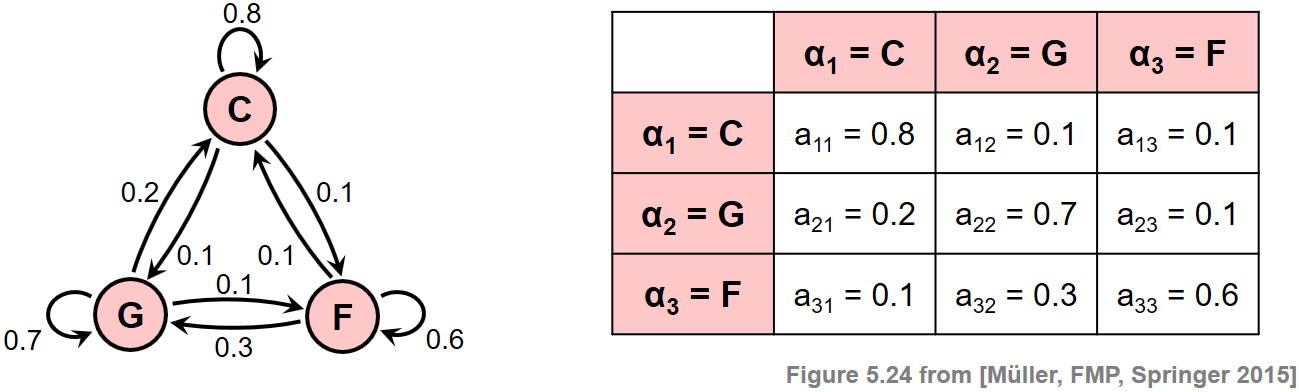

In [2]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F24.png",width="600")

- 모델은 가능한 모든 화음 변화의 확률을 표현한다.
- 주어진 화음 진행의 확률을 계산하려면 모델이 시작되는 방법에 대한 정보도 필요하다.
- 이 정보는 **초기 상태 확률(initial state probabilities)** 이라는 추가 모델 매개변수에 의해 지정된다. 일반적인 Markov 체인의 경우 이러한 확률은 숫자로 지정된다.
    -  $c_{i} := P[s_{1}=\alpha_{i}] \in [0,1]$
    - for $i\in[1:I]$
- 합이 1이 되는 이러한 계수는 길이 $I$의 $C$로 표시되는 벡터로 표현될 수 있다.

## Hidden Markov Models

- Markov 체인을 기반으로 state 또는 화음 유형의 시퀀스로 구성된 주어진 관찰에 대해 확률을 계산할 수 있다. 그러나 화음 인식 시나리오에서 이것이 꼭 필요한 것은 아니다.
- 화음 유형의 시퀀스를 관찰하는 대신 화음 유형과 어떤 식으로든 관련된 **크로마 벡터 시퀀스**를 관찰할 수 있다. 즉, state sequence가 직접적으로 보이지 않고, state sequence를 기반으로 생성된 흐릿한 관찰 시퀀스만 존재한다.
- 이로 인해 Markov 체인이 **Hidden Markov 모델**(HMM)이라고 하는 통계 모델로 확장된다.
- 확률적 프레임워크를 사용하여 관찰된 특징 벡터와 화음 유형(state) 사이의 관계를 나타내는 것이다.
- 각 state는 특정 화음 유형이 특정 특징 벡터를 출력하거나 방출할 가능성을 나타내는 확률 함수를 갖추고 있다.
- 결과적으로 **hidden layer**와 **observable layer**로 구성된 2계층 프로세스를 얻는다.
- hidden layer은 관찰할 수 없는("숨겨진") 상태 시퀀스를 생성하지만, state-dependent 확률 함수를 기반으로 관찰 시퀀스를 생성한다.

- HMM의 **첫 번째 레이어**는 위에서 소개한 **마코프 체인**이다. 
- HMM의 두 번째 레이어를 정의하려면 가능한 출력 값의 공간과 각 상태에 대한 확률 함수를 지정해야 한다. 
- 일반적으로 출력 공간은 실수, 벡터 공간 또는 모든 종류의 특징 공간을 포함하는 모든 집합이 될 수 있다. 예를 들어, 화음 인식의 경우 이 공간은 가능한 모든 $12$ 차원의 크로마 벡터로 구성된 특징 공간 $\mathcal{F}=\mathbb{R}^{12}$으로 모델링될 수 있다. 
- 단순화를 위해 출력 공간이 불연속적이고 유한한 것으로 가정되는 **이산(discrete) HMM**의 경우만 고려한다. 이 경우 공간을 유한 집합으로 모델링할 수 있다.
    - $\mathcal{B} = \{\beta_{1},\beta_{2},\ldots,\beta_{K}\} $
    - 개별 출력 요소 $\beta_{k}$, $k\in[1:K]$로 구성된 $K\in\mathbb{N}$ 크기를 가지며, **관찰 기호(obeservation symbols)** 라고도 한다.

- HMM은 **방출(emission) 확률** 또는 **출력(output) 확률**이라고도 하는 확률 함수를 각 state와 연결한다. 불연속적인 경우 방출 확률은 다음의 계수로 지정된다.
    - $ b_{ik}\in[0,1] $
    - for $i\in[1:I]$ and $k\in[1:K]$
    
- 각 계수 $b_{ik}$는 state $\alpha_{i}$에 있을 때 관측 기호 $\beta_{k}$를 출력할 시스템의 확률을 나타낸다. 
- 상태 전이 확률과 유사하게, 방출 확률은 확률적 제약 조건 $\sum_{k=1}^{K} \beta_{ik} = 1$ for $i\in[1:I]$를 충족하는 데 필요하다(따라서 각 state에 대한 확률 분포 형성). 
- 계수는 $B$로 표시되는 $(I\times K)$ 행렬로 표현할 수 있다. 요약하면 HMM은 다음의 튜플로 지정된다.
    - $\Theta:=(\mathcal{A},A,C,\mathcal{B},B)$

- $\mathcal{A}$ 및 $\mathcal{B}$ 집합은 일반적으로 모델의 고정 구성 요소로 간주되는 반면, $A$, $B$ 및 $C$로 지정된 확률 값은 결정할 수 이쓴 매개변수이다.
- 이는 전문가 자신의 음악 지식 혹은 적절하게 라벨링된 교육 데이터를 기반으로 한 학습 절차를 사용하여 수행할 수 있다.
- 위의 예에 이어 다음 그림은 state-dependent 방출 확률이 점선 화살표의 라벨로 표시되는 Hidden Markov 모델을 보여준다.

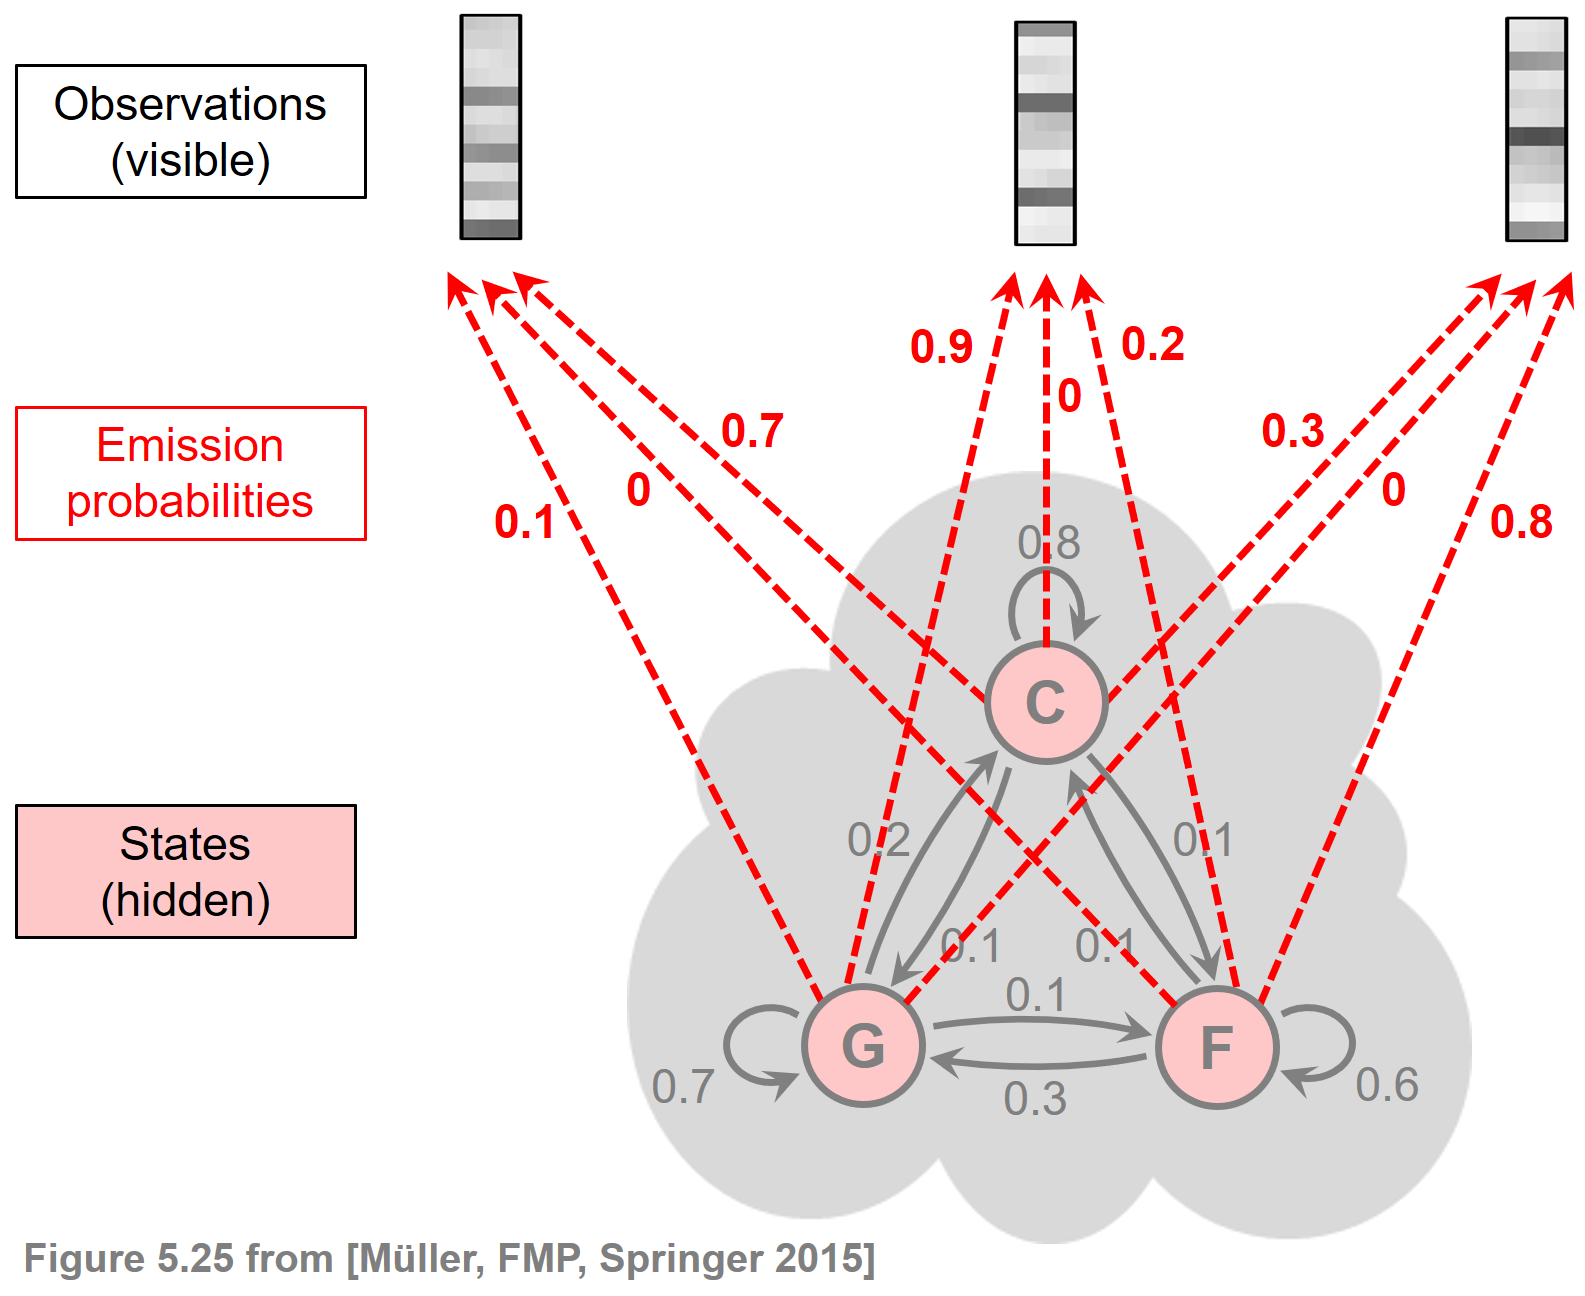

In [3]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F25.png", width="500px")

- 다음 코드 셀에서 그림에 지정된 대로 상태 전이 확률 행렬 $A$와 출력 확률 $B$를 정의한다.
    * 여기서는 $\alpha_{1}=\mathbf{C}$, $\alpha_{2}=\mathbf{G}$, $\alpha_{3}=\mathbf{F}$로 가정한다.
    * 또한 출력 공간 $\mathcal{B} = \{\beta_{1},\beta_{2},\beta_{3}\}$의 요소는 왼쪽에서 오른쪽으로 정렬된 세 개의 크로마 벡터를 나타낸다.
    * 마지막으로 초기 상태 확률 벡터 $C$가 $c_{1}=0.6$, $c_{2}=0.2$, $c_{3}=0.2$ 값으로 주어진다고 가정한다.

In [4]:
A = np.array([[0.8, 0.1, 0.1], 
              [0.2, 0.7, 0.1], 
              [0.1, 0.3, 0.6]])
C = np.array([0.6, 0.2, 0.2])
B = np.array([[0.7, 0.0, 0.3], 
              [0.1, 0.9, 0.0], 
              [0.0, 0.2, 0.8]])

## HMM-Based Sequence Generation 

- HMM이 $\Theta:=(\mathcal{A},A,C,\mathcal{B},B)$로 지정되면, 다양한 분석 및 합성 응용에 사용할 수 있다.

- 이제 주어진 HMM을 기반으로 관측 시퀀스 $O=(o_{1},o_{2},\ldots,o_{N})$ (of length $N\in\mathbb{N}$ with $o_n\in \mathcal{B}$, $n\in[1:N]$)를 (인위적으로) 생성하는 방법에 대해 논의한다.

- 생성 절차는 다음과 같다.
    1. 초기 상태(state) 분포 $C$에 따라 $n=1$로 설정하고 초기 상태 $s_n=\alpha_i$ (for some $i\in[1:I]$)를 선택한다.
    2. $s_n=\alpha_i$ 상태의 방출 확률에 따라 관찰 $o_n=\beta_k$ (for some $k\in[1:K]$)를 생성한다($B$의 $i^{\mathrm{th}}$ 행에 의해 지정됨)
    3. $n=N$이면 프로세스를 종료한다. 그렇지 않고 $n<N$인 경우, 상태 $s_n=\alpha_i$의 상태 전이 확률에 따라 새로운 상태 $s_{n+1}=\alpha_{j}$로 이동한다($A$의 $i^{\mathrm{th}}$ 행에 의해 지정됨). 그런 다음 $n$을 1씩 늘리고 2단계로 돌아간다.

- 다음 코드 셀에서는 이 절차를 구현하고 위에서 지정한 예제 HMM에 적용한다.
- Python 규칙으로 인해 인덱스 `0`부터 구현을 시작합니다.

In [5]:
def generate_sequence_hmm(N, A, C, B, details=False):
    """Generate observation and state sequence from given HMM

    Args:
        N (int): Number of observations to be generated
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        details (bool): If "True" then shows details (Default value = False)

    Returns:
        O (np.ndarray): Observation sequence of length N
        S (np.ndarray): State sequence of length N
    """
    assert N > 0, "N should be at least one"
    I = A.shape[1]
    K = B.shape[1]
    assert I == A.shape[0], "A should be an I-square matrix"
    assert I == C.shape[0], "Dimension of C should be I"
    assert I == B.shape[0], "Column-dimension of B should be I"

    O = np.zeros(N, int)
    S = np.zeros(N, int)
    for n in range(N):
        if n == 0:
            i = np.random.choice(np.arange(I), p=C)
        else:
            i = np.random.choice(np.arange(I), p=A[i, :])
        k = np.random.choice(np.arange(K), p=B[i, :])
        S[n] = i
        O[n] = k
        if details:
            print('n = %d, S[%d] = %d, O[%d] = %d' % (n, n, S[n], n, O[n]))
    return O, S

In [6]:
N = 10
O, S = generate_sequence_hmm(N, A, C, B, details=True)
print('State sequence S:      ', S)
print('Observation sequence O:', O)

n = 0, S[0] = 1, O[0] = 1
n = 1, S[1] = 2, O[1] = 1
n = 2, S[2] = 2, O[2] = 2
n = 3, S[3] = 2, O[3] = 2
n = 4, S[4] = 2, O[4] = 2
n = 5, S[5] = 2, O[5] = 2
n = 6, S[6] = 1, O[6] = 1
n = 7, S[7] = 1, O[7] = 1
n = 8, S[8] = 0, O[8] = 0
n = 9, S[9] = 0, O[9] = 0
State sequence S:       [1 2 2 2 2 2 1 1 0 0]
Observation sequence O: [1 1 2 2 2 2 1 1 0 0]


- 시퀀스 생성 접근 방식의 타당성에 대한 건전성 검사로서 이제 생성된 시퀀스가 HMM의 확률을 잘 반영하는지 확인한다. 이를 위해 생성된 관찰 시퀀스 $O$와 상태 시퀀스 $S$로부터 원래 전이 확률 행렬 $A$와 출력 확률 행렬 $B$를 추정한다.
    * $A$의 $a_{ij}$ 항목의 추정치를 얻기 위해 $S(n)=\alpha_i$ 및 $S(n+1)=\alpha_j$을 사용하여 $n$에서 $n+1$로의 모든 전환을 계산한다. 그런 다음 이 숫자를 $\alpha_i$로 시작해서 총 전환 수로 나눈다.
    * 마찬가지로, $B$의 $b_{ik}$ 항목에 대한 추정치를 얻기 위해 $S(n)=\alpha_i$ 및 $O(n)=\beta_k$에서 발생 횟수 $n$을 계산한다. 이 숫자를 $S$에서 $\alpha_i$의 총 발생 수로 나눈다.

- 숫자 $N$을 증가시켜 더 긴 시퀀스를 생성할 때, 결과 추정치는 $A$ 및 $B$의 원래 값에 근접해야 한다.

- 주의: 실제로 훈련 데이터에서 HMM 모델 매개변수를 추정할 때 일반적으로 **관찰 시퀀스**만 사용할 수 있으며 상태 시퀀스(숨겨진 생성 프로세스를 반영)는 일반적으로 알려져 있지 않다. 관찰 시퀀스에서만 파라미터를 학습하면 아래에서 설명하는 것처럼 훨씬 더 어려운 추정 문제가 발생한다.

In [10]:
def estimate_hmm_from_o_s(O, S, I, K):
    """Estimate the state transition and output probability matrices from
    a given observation and state sequence

    Args:
        O (np.ndarray): Observation sequence of length N
        S (np.ndarray): State sequence of length N
        I (int): Number of states
        K (int): Number of observation symbols

    Returns:
        A_est (np.ndarray): State transition probability matrix of dimension I x I
        B_est (np.ndarray): Output probability matrix of dimension I x K
    """
    # Estimate A
    A_est = np.zeros([I, I])
    N = len(S)
    for n in range(N-1):
        i = S[n]
        j = S[n+1]
        A_est[i, j] += 1
    A_est = normalize(A_est, axis=1, norm='l1')

    # Estimate B
    B_est = np.zeros([I, K])
    for i in range(I):
        for k in range(K):
            B_est[i, k] = np.sum(np.logical_and(S == i, O == k))
    B_est = normalize(B_est, axis=1, norm='l1')
    return A_est, B_est

In [11]:
N = 100
print('======== Estimation results when using N = %d ========' % N)
O, S = generate_sequence_hmm(N, A, C, B, details=False)
A_est, B_est = estimate_hmm_from_o_s(O, S, A.shape[1], B.shape[1])
np.set_printoptions(formatter={'float': "{: 7.3f}".format})
print('A =', A, sep='\n')
print('A_est =', A_est, sep='\n')
print('B =', B, sep='\n')
print('B_est =', B_est, sep='\n')

N = 10000
print('======== Estimation results when using N = %d ========' % N)
O, S = generate_sequence_hmm(N, A, C, B, details=False)
A_est, B_est = estimate_hmm_from_o_s(O, S, A.shape[1], B.shape[1])
np.set_printoptions(formatter={'float': "{: 7.3f}".format})
print('A =', A, sep='\n')
print('A_est =', A_est, sep='\n')
print('B =', B, sep='\n')
print('B_est =', B_est, sep='\n')

======== Estimation results when using N = 100 ========
A =
[[  0.800   0.100   0.100]
 [  0.200   0.700   0.100]
 [  0.100   0.300   0.600]]
A_est =
[[  0.773   0.114   0.114]
 [  0.146   0.756   0.098]
 [  0.286   0.357   0.357]]
B =
[[  0.700   0.000   0.300]
 [  0.100   0.900   0.000]
 [  0.000   0.200   0.800]]
B_est =
[[  0.756   0.000   0.244]
 [  0.171   0.829   0.000]
 [  0.000   0.071   0.929]]
======== Estimation results when using N = 10000 ========
A =
[[  0.800   0.100   0.100]
 [  0.200   0.700   0.100]
 [  0.100   0.300   0.600]]
A_est =
[[  0.789   0.104   0.107]
 [  0.202   0.694   0.103]
 [  0.089   0.305   0.605]]
B =
[[  0.700   0.000   0.300]
 [  0.100   0.900   0.000]
 [  0.000   0.200   0.800]]
B_est =
[[  0.699   0.000   0.301]
 [  0.093   0.907   0.000]
 [  0.000   0.196   0.804]]


## HMM의 세 가지 문제

- 이제 매개변수의 지정 및 관찰 시퀀스의 평가와 관련된 HMM에 대한 세 가지 유명한 알고리즘 문제를 살펴본다.

### 평가 문제 (Evaluation Problem)

- 첫 번째 문제는 **평가 문제**라고 한다. $\Theta=(\mathcal{A},A,C,\mathcal{B},B)$로 지정된 HMM과 관측 시퀀스 $O=(o_{1},o_{2},\ldots,o_{N})$가 주어지면, 주어진 모델의 관찰 시퀀스의 확률 P[O|\Theta]을 계산해야 한다.

- 조금 다른 관점에서 보면, 이 확률은 주어진 모델이 주어진 관측 시퀀스와 얼마나 잘 일치하는지를 나타내는 점수 값으로 볼 수 있다. 이러한 해석은 여러 경쟁 모델 중에서 하나를 선택하려는 경우에 유용하다. 따라서 해결책은 관측 시퀀스와 가장 일치하는 모델을 선택하는 것이다. 
- $P[O|\Theta]$를 계산하기 위해 먼저 길이가 $N$이고 적절한 $i_n\in[1:I]$, $n\in[1:N]$에 대한 $s_n=\alpha_{i_n}\in\mathcal{A}$인 고정 상태 시퀀스 $S=(s_1,s_2,\ldots,s_N)$를 고려한다. 
- 상태 시퀀스 $S$와 관찰 시퀀스 $O$를 생성할 확률 $P[O,S|\Theta]$는 다음과 같이 주어진다.

$$
P[O,S|\Theta] = c_{i_1}\cdot b_{i_1k_1} \cdot a_{i_1i_2}\cdot b_{i_2k_2} \cdot ...\cdot a_{i_{N-1} i_N}\cdot b_{i_Nk_N}
$$


- 다음으로 전체 확률 $P[O|\Theta]$를 얻으려면 $|S|=N$ 길이의 모든 가능한 상태 시퀀스 $S$를 고려하여 이러한 모든 확률을 합산해야 한다.

$$
P[O|\Theta] = \sum_{S: |S|=N}P[O,S|\Theta]
= \sum_{i_1=1}^I \sum_{i_2=1}^I \ldots \sum_{i_N=1}^I
c_{i_1}\cdot b_{i_1k_1} \cdot a_{i_1i_2}\cdot b_{i_2k_2} \cdot ...\cdot a_{i_{N-1}i_N}\cdot b_{i_Nk_N}
$$


- 이는 관찰 시퀀스의 길이 $N$에서 기하급수적인 숫자인 $I^N$ summands로 이어진다. 따라서 실제로 이 잔인한 계산 절차는 작은 $N$에 대해서도 계산적으로 불가능하다. 단, 다이나믹 프로그래밍 패러다임을 기반으로 하는 알고리즘을 사용하여 $P[O|\Theta]$를 계산하는 보다 효율적인 방법이 있다. [**Forward-Backward Algorithm**](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm)이라고 하는 이 절차에는 $I^2N$ ($I^N$ 대신) 정도의 많은 작업이 필요하다.

### Uncovering 문제

- 두번째 문제는 **uncovering problem**이다.
- 다시 $\Theta=(\mathcal{A},A,C,\mathcal{B},B)$로 주어진 HMM과 관찰 시퀀스 $O=(o_{1},o_{2 },\ldots,o_{N})$가 있을 때,
- **모든** 가능한 상태 시퀀스를 고려해야 하는 전체 확률 $P[O|\Theta]$ for $O$를 찾는 대신, uncovering 문제의 목표는 관찰 시퀀스를 "가장 잘 설명"하는 **단일** 상태 시퀀스 $S=(s_{1},s_{2},\ldots,s_{N})$을 찾는 것이다.
- 지금까지 언급된 발견 문제는 일반적으로 관찰 시퀀스를 생성하는 단일의 "올바른" 상태 시퀀스가 없기 때문에 잘 정의되지 않았다. 실제로 최상의 설명력에 대해 의미하는 바를 구체화하는 일종의 최적화 기준이 필요하다.
- 그러한 기준에 대한 몇 가지 합리적인 선택이 있으며, 의도된 응용에 따라 달라진다. 그 중 하나인 효율적인 알고리즘인 **Viterbi algorithm**에 대해 밑에서 논의하기로 한다. 이 알고리즘은 일종의 context-sensitive smoothing 절차로 생각할 수 있다.

### 추정 (Estimation) 문제

- HMM의 세번째 문제는 **estimation problem**이다. 
- 관찰 시퀀스 $O$가 주어지면 목표는 확률 $P[O|\Theta ]$을 최대화하는 $\Theta$의 ($A$, $C$, $B$로 지정된) free model parameter를 결정하는 것이다. 다시말해, 관찰 시퀀스를 가장 잘 설명하는 매개변수를 추정하는 것이다. 
- 이것은 일련의 관찰 시퀀스가 HMM 매개변수를 조정하거나 학습하기 위한 **훈련 자료(training material)** 역할을 하는 **최적화 문제**의 전형적인 예이다.
- 추정 문제는 단연 HMM의 가장 어려운 문제이다. 사실 주어진 최적화 문제를 명시적으로 풀 수 있는 알려진 방법은 없다.
- 다만, 지역적으로 최적해를 찾는 반복적인 절차가 제시되어 왔다. 이러한 절차 중 하나는 [**Baum-Welch 알고리즘**]으로 알려져 있다.

# Viterbi Algorithm

Lawrence R. Rabiner: <strong>A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition.</strong> Proceedings of the IEEE, 77 (1989), pp. 257&ndash;286. 

## Uncovering Problem and Viterbi Algorithm

We now consider the [**uncovering problem**](../C5/C5S3_HiddenMarkovModel.html), which is the problem relevant for our [chord recognition scenario](../C5/C5S2_ChordRec_Templates.html), in more detail. As described in the [FMP notebook on Hidden Markov Models (HMMs)](../C5/C5S3_HiddenMarkovModel.html), the goal is to find the **single** state sequence $S=(s_{1},s_{2},\ldots,s_{N})$ that "best explains" a given observation sequence $O=(o_{1},o_{2},\ldots,o_{N})$. In the chord recognition scenario, the observation sequence is a sequence of [chroma vectors](../C3/C3S1_SpecLogFreq-Chromagram.html) extracted from an audio recording. The optimal state sequence is then the sequence of chord labels, which is the result of the chord recognition procedure. As optimization criterion, one possibility is to choose the state sequence $S^\ast$ that yields the highest probability $\mathrm{Prob}^\ast$ when evaluated against the observation sequence $O$:

\begin{eqnarray}
  \mathrm{Prob}^\ast
  &=& \underset{S=(s_{1},s_{2},\ldots,s_{N})}{\max} \,\,P[O,S|\Theta],\\
  S^\ast 
  &=& \underset{S=(s_{1},s_{2},\ldots,s_{N})}{\mathrm{argmax}} \,\,\,P[O,S|\Theta].
\end{eqnarray}

To find the sequence $S^\ast$ using the naive approach, one would have to compute the probability value $P[O,S|\Theta]$ 
for each of the $I^N$ possible state sequences of length $N$ and then look for the maximizing argument. Fortunately, there is a technique known as the **Viterbi algorithm** for finding the optimizing state sequence in a much more efficient way. The Viterbi algorithm, which is similar to the [DTW algorithm](../C3/C3S2_DTWbasic.html), is based on **dynamic programming**. The idea is to recursively compute an optimal (i.e., probability-maximizing) state sequence from optimal solutions for subproblems, where one considers truncated versions of the observation sequence. Let 
$O=(o_{1},o_{2},\ldots o_{N})$ be the observation sequence. Then, we define the prefix 

$$
O(1\!:\!n):=(o_{1},\ldots,o_{n})
$$ 

of length $n\in[1:N]$ and set

\begin{equation}
   \mathbf{D}(i,n):=\underset{(s_1,\ldots,s_n)}{\max} P[O(1:n),(s_1,\ldots, s_{n-1},s_n=\alpha_i)|\Theta]
\end{equation}

for $i\in[1:I]$. In other words, $\mathbf{D}(i,n)$ is the highest probability along a single state sequence $(s_{1},\ldots,s_{n})$ that accounts for the first $n$ observations and ends in state $s_{n}=\alpha_{i}$. The state sequence yielding the maximal value 

\begin{equation}
\label{eq:ChordReco:HMM:Problems:UncovMax}  
  \mathbf{Prob}^\ast = \underset{i\in[1:I]}{\max}\,\,\mathbf{D}(i,N)
\end{equation}

is the solution to our uncovering problem. The $(I\times N)$ matrix $\mathbf{D}$ can be computed recursively along the column index $n\in[1:N]$. The following table specifies the Viterbi algorithm. For a detailed explanation of the algorithm, we refer to Section 5.3.3.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.

<img src="../data/C5/FMP_C5_T02.png" width="600px" align="middle" alt="FMP_C5_T02">

The following figure illustrates the main steps of the Viterbi algorithm. 

* The blue cells indicate the entries $\mathbf{D}(i,1)$, which serve as **initialization** of the algorithm. 
* The red cells illustrate the computation of the **main iteration**. 
* The black cell indicates the **maximizing index** used for the back tracking to obtain the optimal state sequence. 
* The matrix $E$ is used to keep track of the maximizing indices in the recursion. This information is needed in the second stage when constructing the optimal state sequence using **backtracking**. 

<img src="../data/C5/FMP_C5_F27.png" width="500px" align="middle" alt="FMP_C5_F27">

The overall procedure is similar to the [DTW algorithm](../C3/C3S2_DTWbasic.html), where one first constructs the accumulated cost matrix and then obtains the optimal warping path using backtracking. As illustrated by the previous figure, the Viterbi algorithm proceeds in an iterative fashion building up a graph-like structure with $N$ layers, each consisting of $I$ nodes (the states). Furthermore, two neighboring layers are connected by $I^2$ edges, which also determines the order of the number of operations needed to construct a new layer from a given layer. From this follows that the computational complexity of the Viterbi algorithm is $O(N\cdot I^2)$, which is much better than $O(I^N)$ required for the naive approach.  

## Toy Example

Continuing our toy example from the [FMP notebook on HMMs](../C5/C5S3_HiddenMarkovModel.html), the next figure illustrates the principle of the Viterbi algorithm. At the top, one finds a specification of the HMM. At the bottom, the Viterbi algorithm is applied for an input sequence of length $N=6$.

<img src="../data/C5/FMP_C5_F28a.png" width="600px" align="middle" alt="FMP_C5_F28a">
<img src="../data/C5/FMP_C5_F28b.png" width="600px" align="middle" alt="FMP_C5_F28b">

## Implementation of Viterbi Algorithm

In the next code cell, we provide an implementation of the Viterbi algorithm. 

<div class="alert alert-block alert-warning">
<strong>Note:</strong> Due to Python conventions, the indexing in the implementation starts with index <code>0</code>. Also, there is an index shift when applying the algorithm to our toy example, which becomes <code>O = [0, 2, 0, 2, 2, 1]</code>.
</div>

In [15]:
def viterbi(A, C, B, O):
    """Viterbi algorithm for solving the uncovering problem

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D (np.ndarray): Accumulated probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence

    # Initialize D and E matrices
    D = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D[:, 0] = np.multiply(C, B[:, O[0]])

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_product = np.multiply(A[:, i], D[:, n-1])
            D[i, n] = np.max(temp_product) * B[i, O[n]]
            E[i, n-1] = np.argmax(temp_product)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D, E

In [16]:
# Define model parameters
A = np.array([[0.8, 0.1, 0.1], 
              [0.2, 0.7, 0.1], 
              [0.1, 0.3, 0.6]])

C = np.array([0.6, 0.2, 0.2])

B = np.array([[0.7, 0.0, 0.3], 
              [0.1, 0.9, 0.0], 
              [0.0, 0.2, 0.8]])


O = np.array([0, 2, 0, 2, 2, 1]).astype(np.int32)
#O = np.array([1]).astype(np.int32)
#O = np.array([1, 2, 0, 2, 2, 1]).astype(np.int32)

# Apply Viterbi algorithm
S_opt, D, E = viterbi(A, C, B, O)
#
print('Observation sequence:   O = ', O)
print('Optimal state sequence: S = ', S_opt)
np.set_printoptions(formatter={'float': "{: 7.4f}".format})
print('D =', D, sep='\n')
np.set_printoptions(formatter={'float': "{: 7.0f}".format})
print('E =', E, sep='\n')

Observation sequence:   O =  [0 2 0 2 2 1]
Optimal state sequence: S =  [0 0 0 2 2 1]
D =
[[ 0.4200  0.1008  0.0564  0.0135  0.0033  0.0000]
 [ 0.0200  0.0000  0.0010  0.0000  0.0000  0.0006]
 [ 0.0000  0.0336  0.0000  0.0045  0.0022  0.0003]]
E =
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 2 2]]


##  Log-Domain Implementation of Viterbi Algorithm

In each iteration of the Viterbi algorithm, the accumulated probability values of $\mathbf{D}$ at step $n-1$ are multiplied with two probability values from $A$ and $B$. More precisely, we have

$$
   \mathbf{D}(i,n) = \max_{j\in[1:I]}\big(a_{ij} \cdot\mathbf{D}(j,n-1) \big) \cdot b_{i_{k_n}}.
$$
Since all probability values lie the interval $[0,1]$, the product of such values decreases exponentially with the number $n$ of iterations. As a result, for input sequences $O=(o_{1},o_{2},\ldots o_{N})$ with large $N$, the values in $\mathbf{D}$ typically become extremely small, which may finally lead to a numerical underflow. A well-known trick when dealing with products of probability values is to work in the **log-domain**. To this end, one applies a logarithm to all probability values and **replaces multiplication by summation**. Since the logarithm is a strictly monotonous function, ordering relations are preserved in the log-domain, which allows for transferring operations such as **maximization** or **minimization**.

In the following code cell, we provide a **log variant** of the Viterbi algorithm. This variant yields exactly the same optimal state sequence $S^\ast$ and the same backtracking matrix $E$ as the original algorithm, as well as the accumulated log probability matrix $\log(\mathbf{D})$ (`D_log`) (where the logarithm is applied for each entry). We again test the implementation on our toy example. Furthermore, as a sanity check, we apply the exponential function to the computed log-matrix `D_log`, which should yield the matrix `D` as computed by the original Viterbi algorithm above. 

In [17]:
def viterbi_log(A, C, B, O):
    """Viterbi algorithm (log variant) for solving the uncovering problem

    Args:
        A (np.ndarray): State transition probability matrix of dimension I x I
        C (np.ndarray): Initial state distribution  of dimension I
        B (np.ndarray): Output probability matrix of dimension I x K
        O (np.ndarray): Observation sequence of length N

    Returns:
        S_opt (np.ndarray): Optimal state sequence of length N
        D_log (np.ndarray): Accumulated log probability matrix
        E (np.ndarray): Backtracking matrix
    """
    I = A.shape[0]    # Number of states
    N = len(O)  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    A_log = np.log(A + tiny)
    C_log = np.log(C + tiny)
    B_log = np.log(B + tiny)

    # Initialize D and E matrices
    D_log = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D_log[:, 0] = C_log + B_log[:, O[0]]

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_sum = A_log[:, i] + D_log[:, n-1]
            D_log[i, n] = np.max(temp_sum) + B_log[i, O[n]]
            E[i, n-1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    return S_opt, D_log, E

In [18]:
# Apply Viterbi algorithm (log variant)
S_opt, D_log, E = viterbi_log(A, C, B, O)

print('Observation sequence:   O = ', O)
print('Optimal state sequence: S = ', S_opt)
np.set_printoptions(formatter={'float': "{: 7.2f}".format})
print('D_log =', D_log, sep='\n')
np.set_printoptions(formatter={'float': "{: 7.4f}".format})
print('exp(D_log) =', np.exp(D_log), sep='\n')
np.set_printoptions(formatter={'float': "{: 7.0f}".format})
print('E =', E, sep='\n')

Observation sequence:   O =  [0 2 0 2 2 1]
Optimal state sequence: S =  [0 0 0 2 2 1]
D_log =
[[  -0.87   -2.29   -2.87   -4.30   -5.73 -714.35]
 [  -3.91 -711.57   -6.90 -713.57 -715.00   -7.44]
 [-710.01   -3.39 -712.30   -5.40   -6.13   -8.25]]
exp(D_log) =
[[ 0.4200  0.1008  0.0564  0.0135  0.0033  0.0000]
 [ 0.0200  0.0000  0.0010  0.0000  0.0000  0.0006]
 [ 0.0000  0.0336  0.0000  0.0045  0.0022  0.0003]]
E =
[[0 0 0 0 0]
 [0 0 0 0 2]
 [0 2 0 2 2]]
